<a href="https://colab.research.google.com/github/ishandahal/feature_dimension_analysis/blob/main/Linear_Discriminant_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature Selection using Linear Discriminant Analysis (LDA)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Getting the data 
import pandas as pd

df_wine = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch05/wine.data',
                      header=None)
df_wine.columns = ['Class label','Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
## Splitting the data into training and testing subsets (70-30)%
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=0)

In [ ]:
## Standardizing tha data
## While standardadizing the test set use the mean and std from the training set.
## Do not calculate new parameters for the test set.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
## Calculating mean vectors for each class

np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f"MV {label}: {mean_vecs[label - 1]}")

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


In [ ]:
## Calculating the within-class scatter matrix

d = 13 #no of features
S_W = np.zeros((d,d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d,d)) #scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1) #make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
        S_W += class_scatter        # sum class scatter matrices

print(f"Within-class scatter matrix: {S_W.shape[0]}X{S_W.shape[1]}")

Within-class scatter matrix: 13X13


In [ ]:
## We are assuming that the individual scatter matrices are uniformly distributed which is not 
## true. 
print(f"Class label distribution: {np.bincount(y_train)[1:]}")

Class label distribution: [41 50 33]


In [ ]:
## Scaling (Normalizing by dividing by the no of samples per class) to account for lack of uniform distribution
## This is the same as calculating the covariance matrix

d = 13
S_W = np.zeros((d,d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print(f"Scaled within-class scatter matrix: {S_W.shape[0]}X{S_W.shape[1]}")

Scaled within-class scatter matrix: 13X13


In [ ]:
## Calculating the between-class scatter matrix

mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros_like(S_W)
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  #make column vector
    mean_overall = mean_overall.reshape(d, 1) #make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print(f"Between-class scatter matrix: {S_B.shape[0]}X{S_B.shape[1]}")

Between-class scatter matrix: 13X13


In [ ]:
## Solving the generalized eigenvalue problem instead of decomposition of the cov-mat
# like PCA

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [ ]:
## Listing Eigenvalues and Eigenvectors
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[i, :]) for i in range(len(eigen_vals))]
## Sorting the eigen pairs in descending order
eigen_pairs = sorted(eigen_pairs, key=(lambda x: x[0]), reverse=True)

print(f"Eigenvalues in descending order:")
for i,j in eigen_pairs:
    print(i)

Eigenvalues in descending order:
349.61780890599397
172.7615221897938
3.389259780547781e-14
2.842170943040401e-14
1.9284611807586422e-14
1.9284611807586422e-14
1.8639179987230033e-14
1.8639179987230033e-14
7.057897559458914e-15
7.057897559458914e-15
6.596592553773414e-15
3.81059209269662e-15
3.3908455462202616e-15


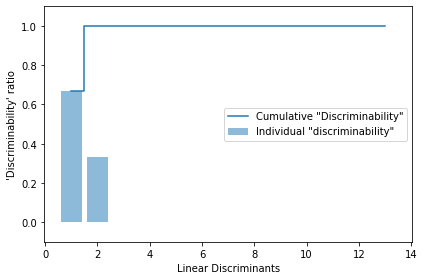

In [ ]:
## Visualizing the discriminants
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative "Discriminability"')
plt.ylabel("'Discriminability' ratio")
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
## Constructing the projection matrix
W = np.hstack((eigen_pairs[0][1][:, None].real,
               eigen_pairs[1][1][:, None].real))
print(f"Matrix W:\n {W}")

Matrix W:
 [[-0.2406 -0.0834]
 [-0.3537 -0.1577]
 [-0.0168  0.0908]
 [ 0.0926  0.1218]
 [-0.0208  0.1597]
 [-0.0208  0.1597]
 [-0.0734 -0.2315]
 [-0.0734 -0.2315]
 [ 0.2639 -0.1361]
 [ 0.2639 -0.1361]
 [ 0.1331 -0.3178]
 [-0.2921 -0.2874]
 [-0.1708 -0.1235]]


In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

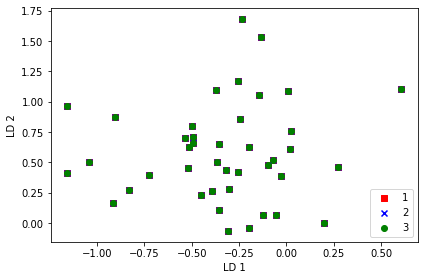

In [ ]:
## Projecting onto new feature space

X_train_std_lda = X_train_std.dot(W)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_std_lda[y_train == 1, 0],
                X_train_std_lda[y_train == 1, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
## LDA using SCIKIT_LEARN

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_std_lda = lda.fit_transform(X_train_std, y_train)

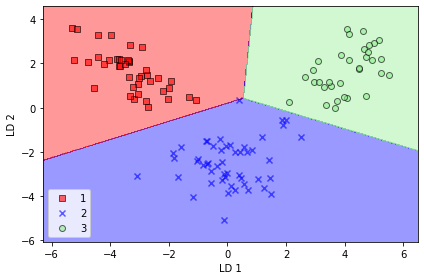

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_std_lda, y_train)

plot_decision_regions(X_train_std_lda, y_train, classifier=lr)
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

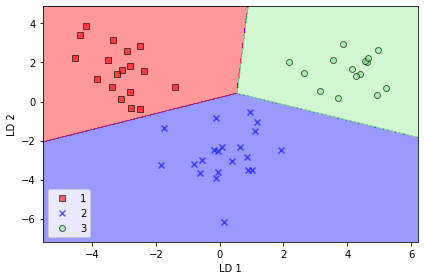

In [ ]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()